In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# 공통

In [ ]:
# 한글 폰트 설치
# 설치 후 런타임 재시작 필수
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install -U gensim
!pip install pyLDAvis

In [ ]:
import pandas as pd
import numpy as np
import re, time
import matplotlib.pyplot as plt

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric , PerplexityMetric
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import pyLDAvis.gensim

## 함수 선언

In [ ]:
def perplexity_coherence(bow_corpus, dictionary, processed_docs, st=2, en=16):
    perplexity = []
    coherence_socre = []

    perplexity = []
    coherence_socre = []
    models = []
    for i in range(st, en):
        lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=i, id2word=dictionary)
        models.append(lda_model)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
        coherence_socre.append(coherence_model_lda.get_coherence())
        perplexity.append(lda_model.log_perplexity(bow_corpus))

    perplexity_change = []
    for i, t in enumerate(perplexity[:-1]):
        perplexity_change.append(perplexity[i+1] - perplexity[i])

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,8))
    fig.suptitle('Perplexity & Coherence Score')
    ax1.plot(range(st, en), perplexity, 'bx-')
    ax2.plot(range(st+1, en), perplexity_change, 'bx-')
    ax3.plot(range(st, en), coherence_socre, 'bx-')

    fig.show()

    return models, coherence_socre

In [ ]:
# path to data dir
path = '/gdrive/My Drive/DIP STUDY/Baseline/LDA/data/'
!ls '/gdrive/My Drive/DIP STUDY/Baseline/LDA/data/'

eng.csv  sample.csv  temp.csv


# English

In [ ]:
# nltk download
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import string

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Load Dataset
df = pd.read_csv(path + 'eng.csv')
df.head(1)

,TITLE,TEXT,PY,Unnamed: 3
0,Cooperative Memory Expansion via OS Kernel Sup...,The growing popularity of in-memory computing ...,2020.0,NaN


## 전처리

### 기본

In [ ]:
# 어근 추출 함수 (동사, 명사)
# shares -> share
# students -> student

def lemma(tok):
    lemmatizer = WordNetLemmatizer()
    result = []
    tag_list=['v','n']
    # res = nltk.pos_tag([tok])
    tag = nltk.pos_tag([tok])[0][1][0].lower()
    if tag not in tag_list:
        return tok
    return lemmatizer.lemmatize(tok, tag).strip()

# 영어가 아닌 문자 제거
def clean_eng(t):
    result = []
    p = re.compile(r"[^a-zA-Z]")
    for w in t.split():
        result.append(re.sub(p, '', w))
    return " ".join(result)

# 불용어 및 글자수 2 이하 제거
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 1:
            result.append(lemma(token))
    return result

In [ ]:
# Select columns to use
df = df[['TITLE', 'TEXT', 'PY']]

# rename columns ex) 논문제목 -> TITLE, '초록 to absatract' , '발행년도' ->'PY'
df = df.rename(columns={'TITLE':'TITLE', 'TEXT':'ABSTRACT', 'PY':'PY'})

# Delete empty Publish Year
df = df[df['PY'].notna()]

# Delete empty title and abstract
df = df[(df['TITLE'].notna()) & df['ABSTRACT'].notna()]

# Delete duplicates
df = df.drop_duplicates('TITLE')

# Combine Title and Abstract
df['TEXT'] = df['TITLE'].astype(str) + ' ' + df['ABSTRACT'].astype(str)
df["TEXT"] = df["TEXT"].str.lower() # 대문자 -> 소문자
df.head()

,TITLE,ABSTRACT,PY,TEXT
0,Cooperative Memory Expansion via OS Kernel Sup...,The growing popularity of in-memory computing ...,2020.0,cooperative memory expansion via os kernel sup...
1,UNIVERSITY STUDENTS' EDUCATION BY MEANS OF ONL...,Introduction. During the past ten years the im...,2020.0,university students' education by means of onl...
2,Cloud Centric Authentication for Wearable Heal...,Security and privacy are the major concerns in...,2020.0,cloud centric authentication for wearable heal...
3,A decade of Google Trends-based Conservation c...,"During the last decade, Conservation culturomi...",2020.0,a decade of google trends-based conservation c...
4,2PBDC: privacy-preserving bigdata collection i...,The combination of two overlapping technologie...,2020.0,2pbdc: privacy-preserving bigdata collection i...


In [ ]:
# Check empty value

df.isna().sum()

TITLE       0
ABSTRACT    0
PY          0
TEXT        0
dtype: int64

In [ ]:
# Text preprocess

df['TEXT'] = df['TEXT'].apply(clean_eng)
processed_docs = df['TEXT'].map(preprocess)
processed_docs[:10]

0     [cooperative, memory, expansion, o, kernel, su...
1     [university, student, education, mean, online,...
2     [cloud, centric, authentication, wearable, hea...
3     [decade, google, trendsbased, conservation, cu...
4     [pbdc, bigdata, collection, cloud, environment...
5     [bigdata, analytics, identifies, metabolic, in...
6     [datadriven, scheduler, performance, model, qo...
7     [lncspa, lncrna, spatial, atlas, expression, n...
9     [comprehensive, overview, oncogenic, pathway, ...
10    [efficient, gene, bigdata, analysis, machine, ...
Name: TEXT, dtype: object

### Gensim 전처리

In [ ]:
# Make dictionary

dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0

len(dictionary)

4105

In [ ]:
# no_below : don't use word exist in less than 15docs
# no_above : don't use word exist in more than 80%
# keep_n : after the above two steps, keep only the first 100000 most frequent tokens.
dictionary.filter_extremes(no_below=0.05, no_above=0.8, keep_n=100000)
len(dictionary)

4104

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


### 최적의 토픽 수 확인 (Perplexity & Coherence Score)

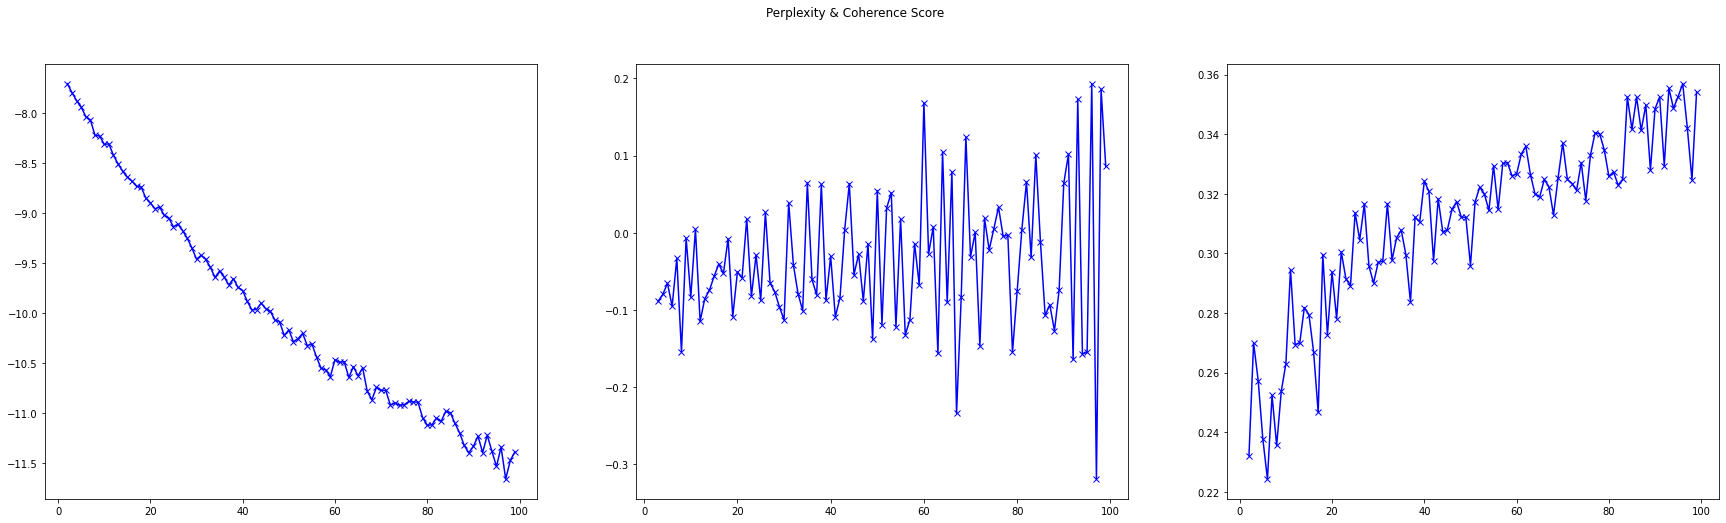

In [ ]:
models, coherence = perplexity_coherence(bow_corpus, dictionary, processed_docs,st=2, en=100)

In [ ]:
for i, co in enumerate(coherence):
    print("Topic : {} \t Coherence Score : {}". format(i+2, round(co,3)))

In [ ]:
lda_model = models[10]

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

0.26939431338914105

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \n Words: {}'.format(idx, topic))

Topic: 0 
 Words: 0.008*"model" + 0.007*"cloud" + 0.006*"bigdata" + 0.006*"analysis" + 0.006*"process" + 0.006*"information" + 0.005*"compute" + 0.005*"method" + 0.005*"disease" + 0.005*"provide"
Topic: 1 
 Words: 0.008*"query" + 0.007*"analysis" + 0.007*"processing" + 0.006*"result" + 0.006*"study" + 0.006*"big" + 0.006*"approach" + 0.006*"time" + 0.005*"research" + 0.005*"health"
Topic: 2 
 Words: 0.008*"service" + 0.008*"lncrnas" + 0.008*"lncrna" + 0.008*"disease" + 0.006*"approach" + 0.006*"human" + 0.006*"provide" + 0.005*"database" + 0.005*"model" + 0.004*"identify"
Topic: 3 
 Words: 0.006*"bigdata" + 0.006*"performance" + 0.006*"database" + 0.006*"method" + 0.006*"application" + 0.006*"disease" + 0.005*"human" + 0.005*"big" + 0.005*"model" + 0.005*"processing"
Topic: 4 
 Words: 0.009*"model" + 0.008*"network" + 0.008*"analysis" + 0.007*"bigdata" + 0.006*"base" + 0.006*"result" + 0.006*"database" + 0.005*"method" + 0.005*"information" + 0.005*"user"
Topic: 5 
 Words: 0.011*"bigda

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.026330  0.018557       1        1  18.631555
4      0.017769 -0.042333       2        1  10.928555
3      0.008984  0.004123       3        1   9.866531
0     -0.000563 -0.057281       4        1   9.346291
7     -0.011615  0.062389       5        1   8.976179
10    -0.083537 -0.021359       6        1   8.609206
1      0.007564 -0.002759       7        1   8.570244
5     -0.000921  0.033555       8        1   6.189527
6      0.015737  0.000205       9        1   5.450995
2      0.067865  0.012769      10        1   4.758196
9     -0.035106  0.005186      11        1   4.433573
8      0.040152 -0.013053      12        1   4.239150, topic_info=             Term        Freq       Total Category  logprob  loglift
502       lncrnas   42.000000   42.000000  Default  30.0000  30.0000
22        compute   76.000000   76.000000  Default  29.0000  29.0000
501        lncrna   29.000000   29.000000  Default  28.0000  28.0000
12        bigdata  157.000000  157.000000  Default  27.0000  27.0000
3178    histogram   12.000000   12.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
69    performance    3.114336   78.830064  Topic12  -5.7274  -0.0705
951      database    3.053670   85.660333  Topic12  -5.7471  -0.1732
237       propose    3.075943   98.249086  Topic12  -5.7398  -0.3031
591     algorithm    2.856553   71.172421  Topic12  -5.8138  -0.0547
80         result    2.851562  107.572631  Topic12  -5.8156  -0.4695

[899 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1181      1  0.166802    ability
1181      2  0.083401    ability
1181      3  0.333604    ability
1181      4  0.083401    ability
1181      5  0.083401    ability
...     ...       ...        ...
1707     12  0.374555     wisdom
3154      5  0.342471        xun
3154      8  0.342471        xun
4067      8  0.685177  zeropower
1439      7  0.616390   zonemaps

[2375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 5, 4, 1, 8, 11, 2, 6, 7, 3, 10, 9])